# Notebook for analyzing Insider tradings and the effects on stock prices
Written by Thomas Niedermayer and Gunnar Sjúrðarson Knudsen, as a conjoined effort for an interdiscplinary project in Data Science.

Supervisor: Wolfgang Aussenegg

Co-Supervisor: Sascha Hunold

Purpose of this notebook is XXX

## Remaining todos:
* Create README.md and add a diagram of the project
* T1_ vs T1!!!
* A lot!
* Figure out which custom functions we are still using
* Figure out if different hypotheses should be tested based on "NAME" - or do both do all analysis?
* Refactor - we have data locations in two different varialbes (CAPS and preceeding underscore)
* I MIGHT have deleted too much from data_checks.run
* Currently have two different datasets for the ReturnIndex data - with (linear) interpolation, as well as skipping rows that don't exist in market and company.
* Figure out what to do, when event date not in the dataset. Could still "just" do closest possible, provided that trades occur around the date.
* What do we do when tickers are non-unique!? I think this is a nasty that breaks more than we know
* document get_all_directors_dealings_async
* Are outliers "Significant"? Wilcoxon compared to t-test

#### Ask Prof. Aussenegg
* How to compare before and after pandemic? subsample to get the same sample size and 2 sample ttest? -> for now, timebased aggregation
* Is it fair to compare like before pandemic with during pandemic? when there is an estimation window in the pre pandemic time and the event window is in the pandemic time
* Are we allowed to persist and upload the preprocessed data for this study?

### Hypotheses

#### Gunnar

1. Hypothesis 1: Insiders are able to earn significant abnormal returns in the first
weeks after disclosure.
2. Hypothesis 2: Trades of type “Purchase” are most explaining of abnormal return.
“Sale” less so, and “Sale + Option” does not have an effect.
3. Hypothesis 3: Directors have changed behaviour during the times of Covid.

#### Tom

1. Hypothesis 1: Insiders are able to earn significant abnormal returns in
the first weeks after disclosure of relevant information.
2. Hypothesis 2: Insiders are significantly good at avoiding risk indicated
by market downturns after insiders selling shares.
3. Hypothesis 3: Directors have changed behaviour during the times of
covid: Hypotheses 1 and 2 can be answered with significantly different
confidence before and during the pandemic.



## Setup

### Define which analysis is run
Add a name here. This affects which data is read in, as well as which analysis are done?

In [53]:
NAME = "Knudsen"
NAME = "Niedermayer"

### Load Libraries

In [54]:
# Standard libraries
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
from tqdm import tqdm
from scipy import stats


# custom functions
import source.analyse_single_company as UASC
from source import data_checks, determine_T0_T1_T2, cut_timeseries, calculate_coefficients
import logging

logging.getLogger().setLevel(logging.WARNING)

#plt.style.use("seaborn")

### Read in the data

In [55]:
# Data locations
DATA_LOCATION = f'data/{NAME}/'
DATA_LOCATION_INSIDER_PROCESSED = DATA_LOCATION + 'processed/insider/'
DATA_LOCATION_RI = DATA_LOCATION + 'processed/RI_discard/'

investigation_periods = {
    "overall": (pd.Timestamp("2018-01-01"), pd.Timestamp("2021-12-31")),
    "pre-pandemic": (pd.Timestamp("2018-01-01"), pd.Timestamp("2020-02-29")),
    "pandemic": (pd.Timestamp("2020-03-01"), pd.Timestamp("2021-12-31")),
}


# Read in the summary data from "CompaniesToExclude" notebook
summary_data = pd.read_csv(DATA_LOCATION + '/scraping_summary.csv', index_col=0)
# Generate list of which companies to analyse
isins_to_use = summary_data[summary_data['reason_to_exclude'] == 'None']['ISIN CODE'].to_list()
display(summary_data)
print(f'We want to reduce to {len(isins_to_use)} isins')

# set plotting sizes
tick_size = 15
label_size = 20
title_size = 30
fig_height = 20

## Not sure why we do this - maybe refactor
_ri_location = DATA_LOCATION_RI
_insider_location = DATA_LOCATION_INSIDER_PROCESSED

# Get locations to read in
file_locs_ = os.listdir(_ri_location)
print(f'Found {len(file_locs_)} possible files to analyze')
# Filter files for analysis, and append path:
file_locs = [_ri_location + f for f in file_locs_ if f[:-7] in isins_to_use]
print(f'We are left with {len(file_locs)} to analyze')

# Actually read in the company information
companies = []
print("loading return series...")
for file_loc in tqdm(file_locs):
    with open(file_loc, "rb") as f:
        company = pickle.load(f)
    companies.append(company)

,ISIN CODE,NAME,TICKER SYMBOL,trade_count,n_distinct_traders,n_distinct_trade_types,ts_rows,reason_to_exclude
764,US35953D1046,FUBOTV,FUBO,40,8,7,1509.0,Faulty timeseries data
954,US46124J2015,INVENTRUST PROPERTIES,IVT,4,4,1,1509.0,Faulty timeseries data
1939,NaN,ABOVENET 'B',ABVT,179,21,10,824.0,Missing ISIN
2093,NaN,ATHENA CONSUMER ACQUISITION CL B,ACAQ,1,1,1,824.0,Missing ISIN
2062,NaN,ARCTIC CAT 'B' DEAD - 07/03/17,ACAT,446,33,8,824.0,Missing ISIN
...,...,...,...,...,...,...,...,...
1057,US53228T1016,LIGHTNING EMOTORS,ZEV,16,13,5,430.0,None
3636,US98979J1097,ZOES KITCHEN DEAD - DELIST.21/11/18,ZOES,87,17,8,675.0,None
1923,US98978V1035,ZOETIS A,ZTS,499,34,8,1509.0,None
1926,US98983L1089,ZURN WATER SOLUTIONS,ZWS,526,27,8,1509.0,None


We want to reduce to 1534 isins
Found 2171 possible files to analyze
We are left with 1534 to analyze
loading return series...


100%|██████████| 1534/1534 [00:02<00:00, 552.38it/s]


## Exploratory Data Analysis

### Calculate Returns, Analyse Companies

In [56]:
print("Returns")
returns_df = [c.return_index_df.company_return for c in companies]

print("concatenate")
df_returns = pd.concat(returns_df, axis=1)
df_return_index = pd.concat([c.return_index_df for c in companies], axis=1)


Returns
concatenate


### Visualise Mean Daily Returns

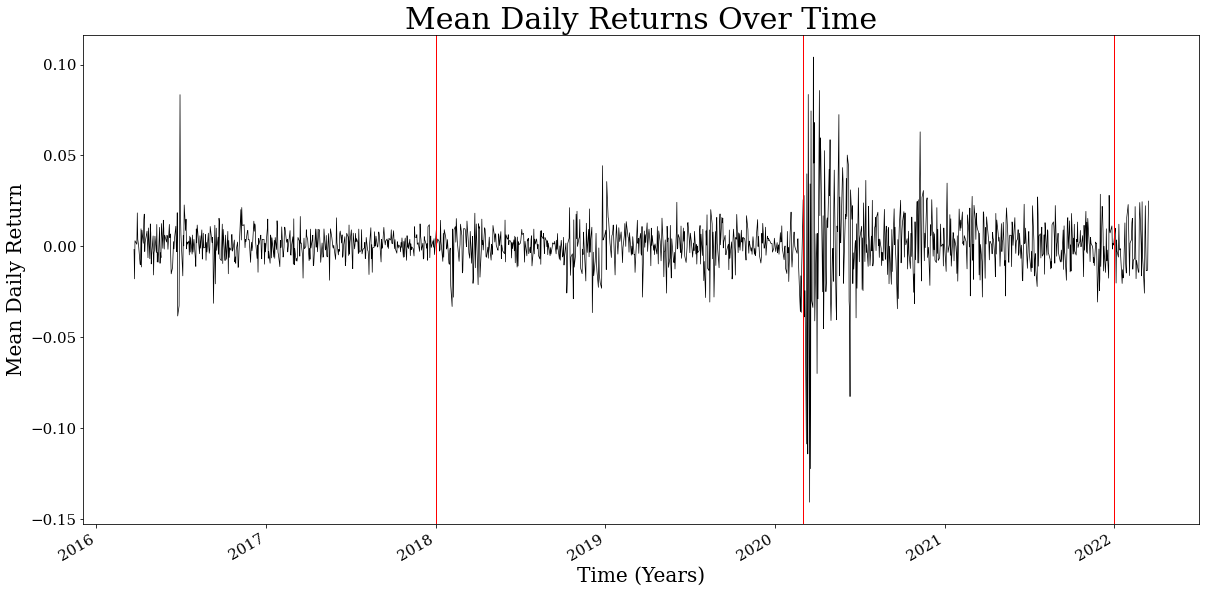

variance of the intervals
0.00009286120000000000
0.00051536910000000004


In [57]:
plt.rc('font', family='serif')
plt.rc('xtick')
plt.rc('ytick')

fig = plt.figure(figsize=(fig_height, 10))
ax = fig.add_subplot(1, 1, 1)

returns_companies = df_returns.mean(axis=1)
returns_companies.plot(color="k", linewidth=0.7)

ax.set_xlabel('Time (Years)', fontsize=label_size)
ax.set_ylabel('Mean Daily Return', fontsize=label_size)
ax.set_title('Mean Daily Returns Over Time', fontsize=title_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

interval_borders = ["2018-01-01", "2020-03-01", "2021-12-31"] # TODO see if it makes sense to actually take first of Feb

for int_ in interval_borders:
    plt.axvline(x = int_, color = 'red', label = 'DD Event time', linewidth = 1)

plt.savefig(DATA_LOCATION +"visualisations/NYSE_daily_returns.svg", dpi=600, bbox_inches='tight')
plt.show()
# get var for the intervals
print("variance of the intervals")
print(f'{round(returns_companies.loc["2018-01-01":"2020-02-29"].var(),10):.20f}')
print(f'{round(returns_companies.loc["2020-03-01":"2021-12-31"].var(), 10):.20f}')


### Remove companies outside of the timeframe of interest

In [58]:
# this is the interval where filings are interesting to us
earliest_timestamp = list(investigation_periods.values())[0][0]
latest_timestamp = list(investigation_periods.values())[-1][1]
filings_removed = 0
filings_total = 0

for company in tqdm(companies):
    insider_data_df = company.insider_data_df
    filing_dates = insider_data_df.FilingDate.apply(lambda x: x.floor("d"))
    mask = (filing_dates >= earliest_timestamp) & (filing_dates <= latest_timestamp)
    company.insider_data_df = company.insider_data_df[mask]
    filings_removed += (~mask).sum()
    filings_total += mask.shape[0]

print("Total filings: {}".format(filings_total))
print("Removed {} filings".format(filings_removed))
print("Remaining filings: {}".format(filings_total - filings_removed))

100%|██████████| 1534/1534 [00:26<00:00, 58.22it/s]

Total filings: 1098006
Removed 807342 filings
Remaining filings: 290664


### Investigate Filing Trade Lag Times

In [59]:
print("get filing lags ...")

lags = []
for company in tqdm(companies):
    lag = UASC.analyse_single_company(company)
    lags.append(lag)


get filing lags ...


100%|██████████| 1534/1534 [00:39<00:00, 38.86it/s]


Negative lag for 10 out of 290664 trades.
Lag longer than 21 days for 5701 out of 290664 trades.
Eligible trades: 284953 out of 290664 trades.


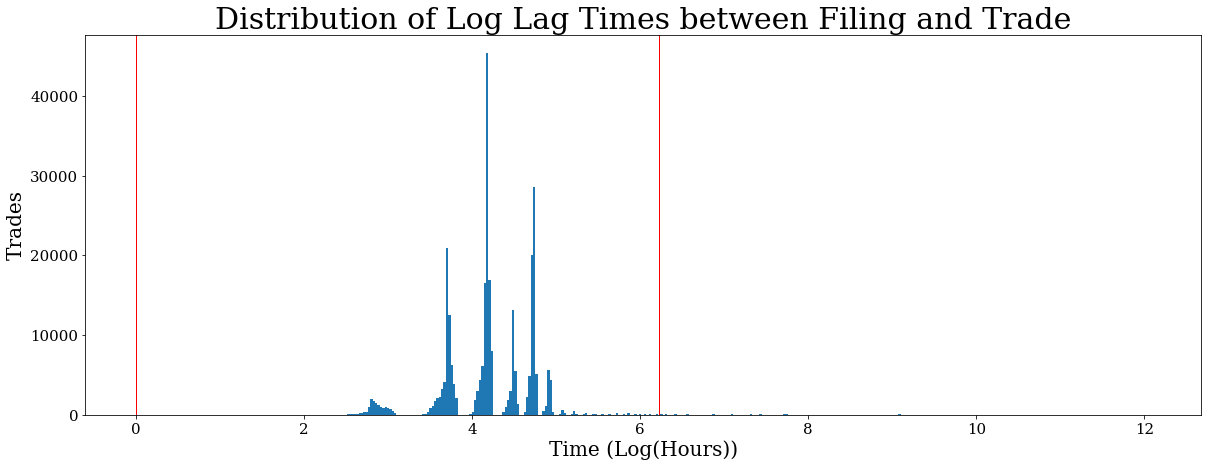

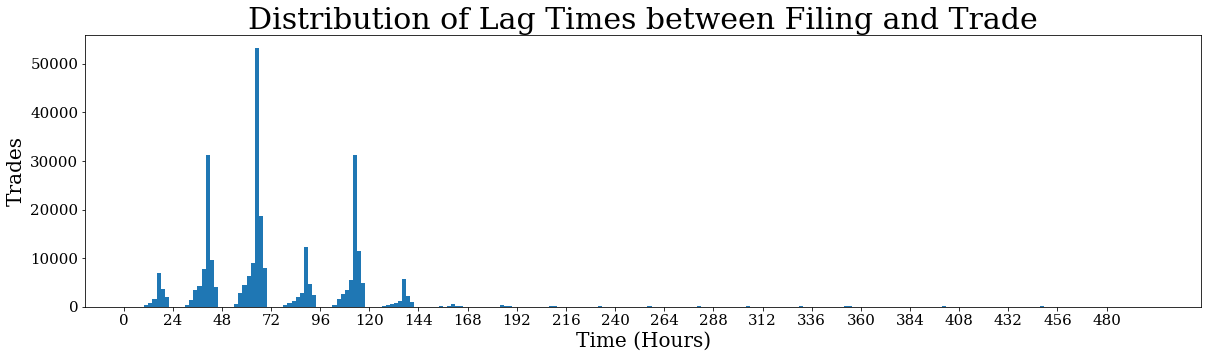

In [60]:
filing_trade_lags = sum(lags, [])

lag_in_hours = np.asarray(filing_trade_lags)
negative_lag_mask = lag_in_hours < 0
positive_lag = lag_in_hours[~negative_lag_mask]
in_21_days = positive_lag < 21*24
relevant_lag = positive_lag[in_21_days]
print(f"Negative lag for {negative_lag_mask.sum()} out of {len(negative_lag_mask)} trades.")
print(f"Lag longer than 21 days for {len(positive_lag) - len(relevant_lag)} out of {len(negative_lag_mask)} trades.")
print(f"Eligible trades: {len(relevant_lag)} out of {len(negative_lag_mask)} trades.")

fig = plt.figure(figsize=(fig_height, 7))
ax = fig.add_subplot(1, 1, 1)
plt.hist(np.log(positive_lag), bins="auto")
ax.set_xlabel('Time (Log(Hours))', fontsize=label_size)
ax.set_ylabel('Trades', fontsize=label_size)
ax.set_title('Distribution of Log Lag Times between Filing and Trade', fontsize=title_size)

plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

plt.axvline(x = 0, color = 'red', label = 'Zero', linewidth = 1)
plt.axvline(x = np.log(21*24), color = 'red', label = 'Threshold', linewidth = 1)
plt.savefig(DATA_LOCATION +"visualisations/log_transformed_lags.svg", dpi=600, bbox_inches='tight')
plt.show()

without_outliers = positive_lag[positive_lag < 24*21]

fig = plt.figure(figsize=(fig_height, 5))
ax = fig.add_subplot(1, 1, 1)
plt.hist(without_outliers, bins="auto")
plt.xticks(np.arange(0, max(without_outliers) + 1, 24))
ax.set_xlabel('Time (Hours)', fontsize=label_size)
ax.set_ylabel('Trades', fontsize=label_size)
ax.set_title('Distribution of Lag Times between Filing and Trade', fontsize=title_size)

plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

plt.savefig(DATA_LOCATION +"visualisations/lags_without_outliers.svg", dpi=600, bbox_inches='tight')
plt.show()

### Drop companies with lags longer than 21 days or negative lags

In [61]:
removed_lags = 0
remaining_lags = 0

for lags_c, company in tqdm(zip(lags, companies)):
    lags_c = np.asarray(lags_c)
    mask_eligible = (lags_c >= 0) & (lags_c <= 21*24)
    company.insider_data_df = company.insider_data_df[mask_eligible]
    removed_lags += (~mask_eligible).sum()
    remaining_lags += mask_eligible.sum()

print(f"Total trades: {removed_lags + remaining_lags}")
print(f"Removed {removed_lags} trades.")
print(f"Remaining {remaining_lags} trades.")


## Demonstrate process for a single event

### Define windows

#### Our data contains multiple companies. A single company contains multiple filings and each filing is an event

![alt text](assets/images/windows.png "Title")

In [62]:
## Constants defining how long both Estimation Window and Event Window are
### Probably also input parameters to a function call, as we need loops later...
L1_length = 100
L2_length = 40 # TODO +-20 days = 40 days, right?

### Fix a company

In [63]:
logging.getLogger().setLevel(logging.DEBUG)

if NAME == "Knudsen":
    company_index = -87
elif NAME == "Niedermayer":
    company_index = -11
else:
    raise NotImplementedError
company = companies[company_index]
print(company)
company_return = company.return_index_df

Company(company_type='2634JX', isin='US98850P1093', name='YUM CHINA HOLDINGS', ticker='YUMC', start_date=Timestamp('2016-10-17 00:00:00'), end_date=datetime.datetime(2022, 3, 16, 0, 0), return_index_df=            ReturnIndex  company_return  market_return
Date                                                  
2016-10-17       100.00             NaN            NaN
2016-10-18        95.28       -0.047200       0.007143
2016-10-19        94.58       -0.007347       0.003133
2016-10-20        94.54       -0.000423      -0.000336
2016-10-21        97.15        0.027607      -0.002404
...                 ...             ...            ...
2022-03-10       180.06       -0.109407      -0.003003
2022-03-11       152.13       -0.155115      -0.011040
2022-03-14       148.36       -0.024781      -0.003767
2022-03-15       160.62        0.082637       0.012828
2022-03-16       175.84        0.094758       0.023014

[1363 rows x 3 columns], insider_data_df=     X          FilingDate  TradeDate Tic

### Fix an event

In [64]:
# This date will be moved to a loop
## Define which periods we are looking at.

if NAME == "Knudsen":
    event_index = 60
elif NAME == "Niedermayer":
    event_index = -200
else:
    raise NotImplementedError
    
event_timestamp = company.insider_data_df.FilingDate.iloc[event_index].floor("d")
print("event timestamp: ", event_timestamp)

event timestamp:  2021-02-11 00:00:00


### Technical Checks

In [65]:
data_checks.run(L1_length, L2_length, event_timestamp, company_return)#, market_timeseries)

In [66]:
#company_return

### Determine T0, T1 and T2

In [67]:
T0_, T1_, T2_, T0, T1, T2, ERROR, msg = determine_T0_T1_T2.run(L1_length, L2_length, event_timestamp, company_return)#, market_timeseries)

DEBUG:root:Found T1 to be 2021-01-13 00:00:00 on index 1067
DEBUG:root:Found T2 to be 2021-03-12 00:00:00 on index 1107
DEBUG:root:Found T0 to be 2020-08-20 00:00:00 on index 967
DEBUG:root:------------------------------
DEBUG:root:Event occurred at             2021-02-11 00:00:00
DEBUG:root:Estimation Window (100 days): from 2020-08-20 00:00:00 to 2021-01-13 00:00:00
DEBUG:root:Event Window      ( 40 days): from 2021-01-13 00:00:00 to 2021-03-12 00:00:00


In [68]:
print(event_timestamp)
company_return

2021-02-11 00:00:00


,ReturnIndex,company_return,market_return
Date,,,
2016-10-17,100.00,NaN,NaN
2016-10-18,95.28,-0.047200,0.007143
2016-10-19,94.58,-0.007347,0.003133
2016-10-20,94.54,-0.000423,-0.000336
2016-10-21,97.15,0.027607,-0.002404
...,...,...,...
2022-03-10,180.06,-0.109407,-0.003003
2022-03-11,152.13,-0.155115,-0.011040
2022-03-14,148.36,-0.024781,-0.003767


### Abnormal and Normal Returns

![alt text](assets/images/return_estimation.png "Title")

### Cut return timeseries into correct periods

In [69]:
windows = cut_timeseries.run(company_return, T0, T1, T2)
estimation_window_market_return, estimation_window_company_return, event_window_market_return, event_window_company_return = windows

DEBUG:root:shapes (Shouldnt be an issue after better preprocessing)
DEBUG:root:# estimation_window_market_return: (100,)
DEBUG:root:# estimation_window_market_return: (100,)
DEBUG:root:# event_window_market_return: (41,)
DEBUG:root:# event_window_company_return: (41,)


### Calculate coefficients

In [70]:
alpha, beta, eps = calculate_coefficients.run(estimation_window_market_return, estimation_window_company_return)

DEBUG:root:                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     28.31
Date:                Fri, 23 Sep 2022   Prob (F-statistic):           6.54e-07
Time:                        18:21:39   Log-Likelihood:                 283.44
No. Observations:                 100   AIC:                            -562.9
Df Residuals:                      98   BIC:                            -557.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.2

### The Abnormal Return
This is the last step of the whole process for one event

In [71]:
company_return = event_window_company_return
market_return = event_window_market_return
estimated_return = alpha + beta*market_return
abnormal_return = company_return - estimated_return
print(abnormal_return)

Date
2021-01-13    0.005520
2021-01-14   -0.018376
2021-01-15    0.002065
2021-01-19    0.033015
2021-01-20   -0.009229
2021-01-21    0.008785
2021-01-22   -0.006243
2021-01-25   -0.004721
2021-01-26    0.020355
2021-01-27   -0.002115
2021-01-28   -0.026937
2021-01-29    0.008670
2021-02-01    0.009054
2021-02-02    0.004114
2021-02-03   -0.023990
2021-02-04   -0.029093
2021-02-05    0.020921
2021-02-08    0.032259
2021-02-09    0.022988
2021-02-10   -0.010210
2021-02-11    0.019935
2021-02-12    0.010480
2021-02-16    0.025953
2021-02-17   -0.001255
2021-02-18   -0.007922
2021-02-19   -0.014811
2021-02-22   -0.015449
2021-02-23   -0.022933
2021-02-24   -0.004807
2021-02-25    0.013430
2021-02-26    0.004602
2021-03-01   -0.015240
2021-03-02   -0.004020
2021-03-03    0.009235
2021-03-04    0.004855
2021-03-05    0.006890
2021-03-08    0.007714
2021-03-09    0.004735
2021-03-10   -0.020458
2021-03-11    0.011022
2021-03-12   -0.010399
dtype: float64


<AxesSubplot:xlabel='Date'>

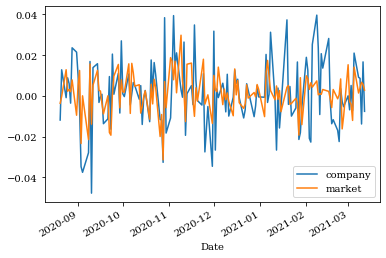

In [72]:
company_and_estimated = pd.DataFrame({"company":event_window_company_return, "market":estimated_return})
company_and_market = pd.DataFrame({"company": estimation_window_company_return, "market":estimation_window_market_return})
df_to_plot = pd.concat([company_and_market, company_and_estimated])
df_to_plot.plot()

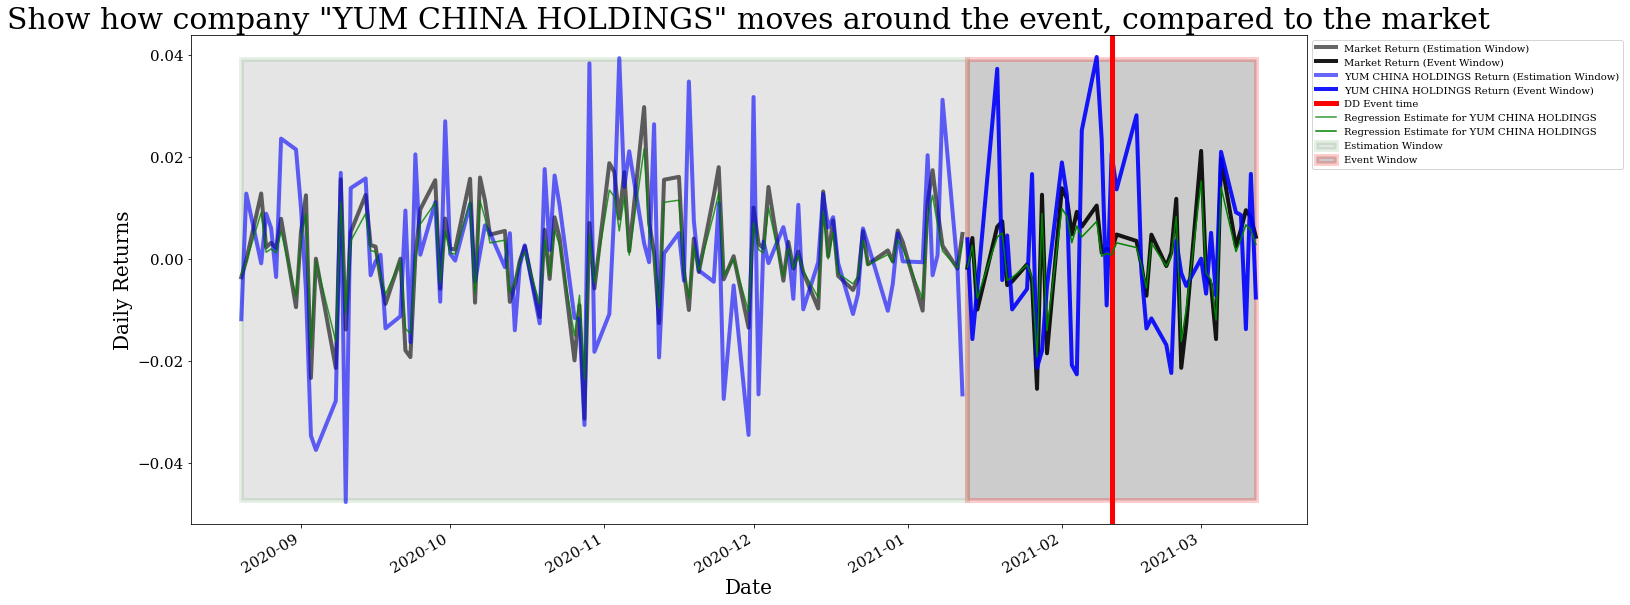

I'm impressed! It looks like a five-year-old drew this plot in paint


In [73]:
Company_name = company.name

# Estimations
est_estimation = estimation_window_market_return * beta + alpha
est_event = event_window_market_return * beta + alpha

plt.figure(figsize=(fig_height,10))
estimation_window_market_return.plot(color = 'black', alpha = 0.6, linewidth=4, label = 'Market Return (Estimation Window)')
event_window_market_return.plot(color = 'black', alpha = 0.9, linewidth=4, label = 'Market Return (Event Window)')

estimation_window_company_return.plot(color = 'blue', alpha = 0.6, linewidth = 4, label = f'{Company_name} Return (Estimation Window)')
event_window_company_return.plot(color = 'blue', alpha = 0.9, linewidth = 4, label = f'{Company_name} Return (Event Window)')

plt.axvline(x = event_timestamp, color = 'red', label = 'DD Event time', linewidth = 5)
plt.ylabel(f'Daily Returns', fontsize=label_size)
est_estimation.plot(color = 'green', label = f'Regression Estimate for {Company_name}', alpha = 0.8)
est_event.plot(color = 'green', label = f'Regression Estimate for {Company_name}', alpha = 1)

plt.axvspan(T0, T1, ymin = 0.05, ymax = 0.95, facecolor='black', alpha=0.1, label = 'Estimation Window', edgecolor='g', linewidth=5)
plt.axvspan(T1, T2, ymin = 0.05, ymax = 0.95, facecolor='black', alpha=0.2, label = 'Event Window', edgecolor='r', linewidth=5)
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')

plt.title(f'Show how company "{Company_name}" moves around the event, compared to the market', fontsize = title_size)
plt.xlabel('Date', fontsize=label_size)

plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.show()
print("I'm impressed! It looks like a five-year-old drew this plot in paint")


In [74]:
EVENT_INDEX = 20 # because 20 [0,..19] are before the event

## Macro Analysis

### Now that we have seen the process for one single filing, let us do the same for all filings in all companies


In [75]:
# Initialize testing
logging.getLogger().setLevel(logging.ERROR)

# Helpers
multiind, data, data_errors = [], [], []
n_companies = len(companies)


for j in tqdm(range(len(companies[:200]))):
#for j in tqdm(range(len(companies))):
    # Get information from said company
    company = companies[j]
    company_return = company.return_index_df
    
    n_filings = len(company.insider_data_df)
    # Go through all filings
    for i in company.insider_data_df.FilingDate.index:


        # TODO probably not used anymore
        # Find our event date from filing
        filing_date = company.insider_data_df.FilingDate[i]
        event_timestamp = filing_date.floor("d")

        checks = data_checks.run(L1_length, L2_length, event_timestamp, company_return)
        if checks:
            #print(checks[1])
            data_errors.append(checks[0])
            continue
   
        ## Proceed to find periods
        T0_, T1_, T2_, T0, T1, T2, ERRORS, msg = determine_T0_T1_T2.run(L1_length, L2_length, event_timestamp, company_return)
        if ERRORS:
            #print(msg)
            data_errors.append(ERRORS)
            continue
            
        ## Cut timeseries to the relevant periods, and split them
        windows = cut_timeseries.run(company_return, T0, T1, T2)
        estimation_window_market_return, estimation_window_company_return,event_window_market_return, event_window_company_return = windows
        alpha, beta, eps = calculate_coefficients.run(estimation_window_market_return, estimation_window_company_return)

        ## Calculate the abnormal returns
        abnormal_return = event_window_company_return - alpha - beta*event_window_market_return
        
        ## Append to results set
        multiind.append((company.ticker, i, company.insider_data_df.TradeType[i], event_timestamp))
        data.append(abnormal_return)

100%|██████████| 200/200 [02:36<00:00,  1.28it/s]


In [76]:
# process abnormal returns
df_abnormal_returns = pd.DataFrame.from_records([d.reset_index(drop=True) for d in data])
df_abnormal_returns.index = pd.MultiIndex.from_tuples(multiind, names=["Company", "i", "TradeType", "event_timestamp"])
df_abnormal_returns

0         1         2         3   \
Company i   TradeType event_timestamp                                           
SLB     59  A - Grant 2021-02-11      -0.022133  0.010547 -0.018312  0.006488   
        60  A - Grant 2021-02-11      -0.022133  0.010547 -0.018312  0.006488   
        61  S - Sale  2021-02-11      -0.022133  0.010547 -0.018312  0.006488   
        62  F - Tax   2021-02-11      -0.022133  0.010547 -0.018312  0.006488   
        63  M - OptEx 2021-02-11      -0.022133  0.010547 -0.018312  0.006488   
...                                         ...       ...       ...       ...   
AWK     285 F - Tax   2021-02-11       0.023160 -0.012939  0.016646 -0.006443   
        286 F - Tax   2021-02-11       0.023160 -0.012939  0.016646 -0.006443   
        287 F - Tax   2021-02-11       0.023160 -0.012939  0.016646 -0.006443   
        288 F - Tax   2021-02-11       0.023160 -0.012939  0.016646 -0.006443   
        289 F - Tax   2021-02-11       0.023160 -0.012939  0.016646 -0.006443   

                                             4         5         6         7   \
Company i   TradeType event_timestamp                                           
SLB     59  A - Grant 2021-02-11      -0.019138 -0.034308  0.018976 -0.025057   
        60  A - Grant 2021-02-11      -0.019138 -0.034308  0.018976 -0.025057   
        61  S - Sale  2021-02-11      -0.019138 -0.034308  0.018976 -0.025057   
        62  F - Tax   2021-02-11      -0.019138 -0.034308  0.018976 -0.025057   
        63  M - OptEx 2021-02-11      -0.019138 -0.034308  0.018976 -0.025057   
...                                         ...       ...       ...       ...   
AWK     285 F - Tax   2021-02-11       0.021674 -0.012318  0.002635  0.002493   
        286 F - Tax   2021-02-11       0.021674 -0.012318  0.002635  0.002493   
        287 F - Tax   2021-02-11       0.021674 -0.012318  0.002635  0.002493   
        288 F - Tax   2021-02-11       0.021674 -0.012318  0.002635  0.002493   
        289 F - Tax   2021-02-11       0.021674 -0.012318  0.002635  0.002493   

                                             8         9   ...        31  \
Company i   TradeType event_timestamp                      ...             
SLB     59  A - Grant 2021-02-11      -0.032082  0.015824  ... -0.018061   
        60  A - Grant 2021-02-11      -0.032082  0.015824  ... -0.018061   
        61  S - Sale  2021-02-11      -0.032082  0.015824  ... -0.018061   
        62  F - Tax   2021-02-11      -0.032082  0.015824  ... -0.018061   
        63  M - OptEx 2021-02-11      -0.032082  0.015824  ... -0.018061   
...                                         ...       ...  ...       ...   
AWK     285 F - Tax   2021-02-11      -0.009174 -0.001524  ...  0.002801   
        286 F - Tax   2021-02-11      -0.009174 -0.001524  ...  0.002801   
        287 F - Tax   2021-02-11      -0.009174 -0.001524  ...  0.002801   
        288 F - Tax   2021-02-11      -0.009174 -0.001524  ...  0.002801   
        289 F - Tax   2021-02-11      -0.009174 -0.001524  ...  0.002801   

                                             32        33        34        35  \
Company i   TradeType event_timestamp                                           
SLB     59  A - Grant 2021-02-11      -0.012906  0.019432  0.042420 -0.026402   
        60  A - Grant 2021-02-11      -0.012906  0.019432  0.042420 -0.026402   
        61  S - Sale  2021-02-11      -0.012906  0.019432  0.042420 -0.026402   
        62  F - Tax   2021-02-11      -0.012906  0.019432  0.042420 -0.026402   
        63  M - OptEx 2021-02-11      -0.012906  0.019432  0.042420 -0.026402   
...                                         ...       ...       ...       ...   
AWK     285 F - Tax   2021-02-11      -0.028449 -0.050857  0.030597 -0.003598   
        286 F - Tax   2021-02-11      -0.028449 -0.050857  0.030597 -0.003598   
        287 F - Tax   2021-02-11      -0.028449 -0.050857  0.030597 -0.003598   
        288 F - Tax   2021-02-11      -0.028449 -0.050857

In [77]:
df_abnormal_returns.describe()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
count,32437.000000,32437.000000,32437.000000,32437.000000,32437.000000,32437.000000,32437.000000,32437.000000,32437.000000,32437.000000,...,32437.000000,32437.000000,32437.000000,32437.000000,32437.000000,32437.000000,32437.000000,32437.000000,32437.000000,32437.000000
mean,-0.004750,0.003983,-0.001526,0.001578,-0.006093,-0.006262,0.006166,-0.003717,0.001662,0.030597,...,-0.002935,-0.002142,0.005250,0.002134,-0.004822,0.009146,-0.005866,0.003358,-0.000920,0.001968
std,0.023258,0.022959,0.021725,0.036436,0.019864,0.021024,0.026233,0.034723,0.033506,0.274227,...,0.027199,0.024836,0.027934,0.026988,0.031763,0.029793,0.026331,0.026451,0.022547,0.024300
min,-0.096817,-0.034710,-0.083124,-0.080841,-0.111768,-0.115687,-0.056003,-0.078062,-0.084461,-0.110060,...,-0.077737,-0.104633,-0.078439,-0.135239,-0.170915,-0.105082,-0.067010,-0.082814,-0.074660,-0.086133
25%,-0.018780,-0.011467,-0.013953,-0.013255,-0.016586,-0.014476,-0.007155,-0.017156,-0.013845,-0.015892,...,-0.015335,-0.017137,-0.011646,-0.011722,-0.014868,-0.005437,-0.023682,-0.007769,-0.013107,-0.009266
50%,-0.002051,0.000178,-0.002114,-0.000422,-0.005691,-0.006050,0.002930,-0.005873,-0.001273,0.000739,...,-0.001042,0.001265,0.004950,0.003918,-0.001595,0.008401,-0.008357,0.003434,-0.003793,0.000847
75%,0.005890,0.012388,0.007213,0.008031,0.004255,0.002468,0.012966,0.004583,0.008972,0.022063,...,0.008583,0.009950,0.019432,0.012704,0.011066,0.022343,0.009411,0.011250,0.009599,0.010094
max,0.100951,0.216206,0.111857,0.303145,0.058208,0.072099,0.202784,0.281818,0.294110,3.106239,...,0.123647,0.079864,0.129158,0.123298,0.155741,0.156630,0.121972,0.151992,0.074829,0.163397


### Show the reasons filings were dropped

In [78]:
errors_df = pd.DataFrame.from_records(data_errors)
errors_agg = errors_df.sum(axis=0)

In [79]:
# add earlier filtering
errors_agg["event not in overall time frame"] = filings_removed
errors_agg["negative lags"] = negative_lag_mask.sum()
errors_agg["more than 21 days lag"] = len(positive_lag) - len(relevant_lag)

In [80]:
errors_agg = pd.DataFrame(errors_agg)
errors_agg.index.name = "Reason"
errors_agg.columns = ["Count"]

In [81]:
print(errors_agg.astype(int).reset_index().to_latex(index=False))

\begin{tabular}{lr}
\toprule
                                        Reason &  Count \\
\midrule
event\_timestamp not in the company return data &   1706 \\
  Not enough days before event in company data &    205 \\
               event not in overall time frame & 807342 \\
                                 negative lags &     10 \\
                         more than 21 days lag &   5701 \\
\bottomrule
\end{tabular}



C:\Users\Tom\AppData\Local\Temp\ipykernel_25036\1687419587.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(errors_agg.astype(int).reset_index().to_latex(index=False))


In [82]:
print(errors_agg.sum())

Count    814964.0
dtype: float64


### Having a look at all trade types together

In [83]:
types_of_interest = ["P - Purchase", "S - Sale", "S - Sale+OE"]
df_abnormal_returns.loc[:,:,types_of_interest,:]

0         1         2   \
Company i   TradeType    event_timestamp                                 
SLB     162 P - Purchase 2021-02-11      -0.022133  0.010547 -0.018312   
        163 P - Purchase 2021-02-11      -0.022133  0.010547 -0.018312   
        203 P - Purchase 2021-02-11      -0.022133  0.010547 -0.018312   
        204 P - Purchase 2021-02-11      -0.022133  0.010547 -0.018312   
        205 P - Purchase 2021-02-11      -0.022133  0.010547 -0.018312   
...                                            ...       ...       ...   
AWK     232 S - Sale+OE  2021-02-11       0.023160 -0.012939  0.016646   
        234 S - Sale+OE  2021-02-11       0.023160 -0.012939  0.016646   
        236 S - Sale+OE  2021-02-11       0.023160 -0.012939  0.016646   
        238 S - Sale+OE  2021-02-11       0.023160 -0.012939  0.016646   
        240 S - Sale+OE  2021-02-11       0.023160 -0.012939  0.016646   

                                                3         4         5   \
Company i   TradeType    event_timestamp                                 
SLB     162 P - Purchase 2021-02-11       0.006488 -0.019138 -0.034308   
        163 P - Purchase 2021-02-11       0.006488 -0.019138 -0.034308   
        203 P - Purchase 2021-02-11       0.006488 -0.019138 -0.034308   
        204 P - Purchase 2021-02-11       0.006488 -0.019138 -0.034308   
        205 P - Purchase 2021-02-11       0.006488 -0.019138 -0.034308   
...                                            ...       ...       ...   
AWK     232 S - Sale+OE  2021-02-11      -0.006443  0.021674 -0.012318   
        234 S - Sale+OE  2021-02-11      -0.006443  0.021674 -0.012318   
        236 S - Sale+OE  2021-02-11      -0.006443  0.021674 -0.012318   
        238 S - Sale+OE  2021-02-11      -0.006443  0.021674 -0.012318   
        240 S - Sale+OE  2021-02-11      -0.006443  0.021674 -0.012318   

                                                6         7         8   \
Company i   TradeType    event_timestamp                                 
SLB     162 P - Purchase 2021-02-11       0.018976 -0.025057 -0.032082   
        163 P - Purchase 2021-02-11       0.018976 -0.025057 -0.032082   
        203 P - Purchase 2021-02-11       0.018976 -0.025057 -0.032082   
        204 P - Purchase 2021-02-11       0.018976 -0.025057 -0.032082   
        205 P - Purchase 2021-02-11       0.018976 -0.025057 -0.032082   
...                                            ...       ...       ...   
AWK     232 S - Sale+OE  2021-02-11       0.002635  0.002493 -0.009174   
        234 S - Sale+OE  2021-02-11       0.002635  0.002493 -0.009174   
        236 S - Sale+OE  2021-02-11       0.002635  0.002493 -0.009174   
        238 S - Sale+OE  2021-02-11       0.002635  0.002493 -0.009174   
        240 S - Sale+OE  2021-02-11       0.002635  0.002493 -0.009174   

                                                9   ...        31        32  \
Company i   TradeType    event_timestamp            ...                       
SLB     162 P - Purchase 2021-02-11       0.015824  ... -0.018061 -0.012906   
        163 P - Purchase 2021-02-11       0.015824  ... -0.018061 -0.012906   
        203 P - Purchase 2021-02-11       0.015824  ... -0.018061 -0.012906   
        204 P - Purchase 2021-02-11       0.015824  ... -0.018061 -0.012906   
        205 P - Purchase 2021-02-11       0.015824  ... -0.018061 -0.012906   
...                                            ...  ...       ...       ...   
AWK     232 S - Sale+OE  2021-02-11      -0.001524  ...  0.002801 -0.028449   
        234 S - Sale+OE  2021-02-11      -0.001524  ...  0.002801 -0.028449   
        236 S - Sale+OE  2021-02-11      -0.001524  ...  0.002801 -0.028449   
        238 S - Sale+OE  2021-02-11      -0.001524  ...  0.002801 -0.028449   
        240 S - Sale+OE  2021-02-11      -0.001524  ...  0.002801 -0.028449   

                                                33        34        35  \
Company i   TradeType    event_timestamp                 

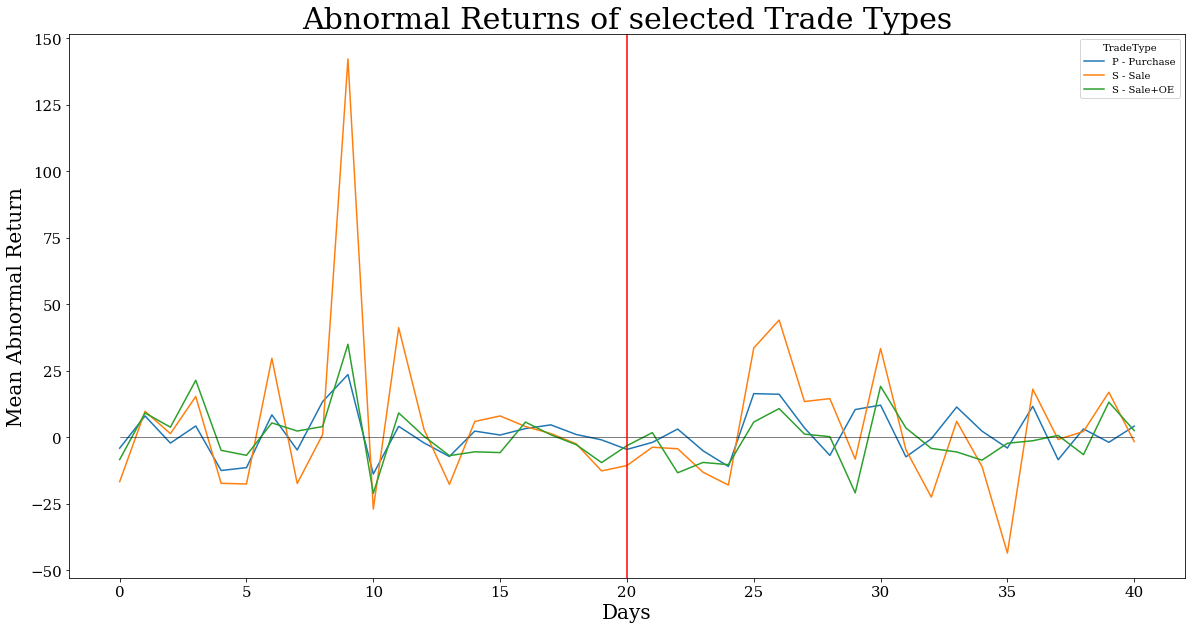

In [84]:

a = df_abnormal_returns.loc[:,:,types_of_interest,:].groupby(level=[2]).sum().transpose().plot(figsize=(fig_height, 10))
plt.plot(np.zeros(len(df_abnormal_returns.columns)), color="black", linewidth=0.5)
a.set_title("Abnormal Returns of selected Trade Types",fontsize=title_size)
a.set_xlabel("Days", fontsize=label_size)
a.set_ylabel("Mean Abnormal Return", fontsize=label_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.axvline(x = EVENT_INDEX, color = 'red', label = 'DD Event time', linewidth = 1.5)
plt.savefig(f"data/{NAME}/visualisations/AR_selected_tradetypes.svg", dpi=600, bbox_inches='tight')

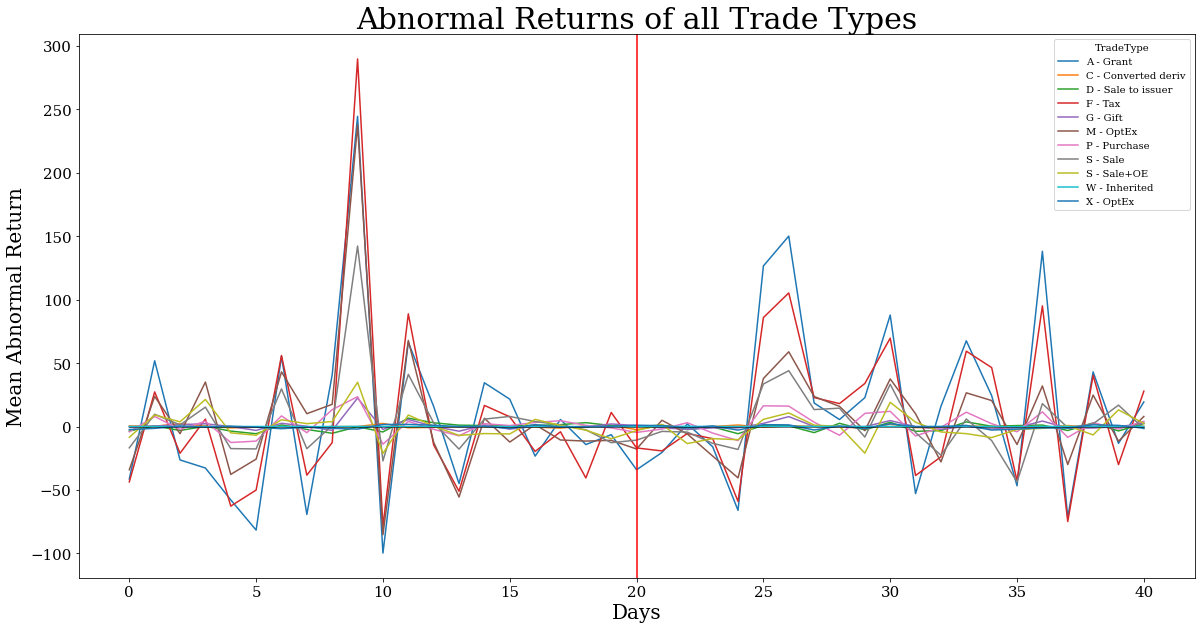

In [85]:
a = df_abnormal_returns.groupby(level=[2]).sum().transpose().plot(figsize=(fig_height, 10), fontsize=15)
plt.plot(np.zeros(len(df_abnormal_returns.columns)), color="black", linewidth=0.5)
a.set_title("Abnormal Returns of all Trade Types",fontsize=title_size)
a.set_xlabel("Days", fontsize=label_size)
a.set_ylabel("Mean Abnormal Return", fontsize=label_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.axvline(x = EVENT_INDEX, color = 'red', label = 'DD Event time', linewidth = 1.5)
plt.savefig(f"data/{NAME}/visualisations/AR_all_tradetypes.svg", dpi=600, bbox_inches='tight')

In [86]:
df_abnormal_returns

0         1         2         3   \
Company i   TradeType event_timestamp                                           
SLB     59  A - Grant 2021-02-11      -0.022133  0.010547 -0.018312  0.006488   
        60  A - Grant 2021-02-11      -0.022133  0.010547 -0.018312  0.006488   
        61  S - Sale  2021-02-11      -0.022133  0.010547 -0.018312  0.006488   
        62  F - Tax   2021-02-11      -0.022133  0.010547 -0.018312  0.006488   
        63  M - OptEx 2021-02-11      -0.022133  0.010547 -0.018312  0.006488   
...                                         ...       ...       ...       ...   
AWK     285 F - Tax   2021-02-11       0.023160 -0.012939  0.016646 -0.006443   
        286 F - Tax   2021-02-11       0.023160 -0.012939  0.016646 -0.006443   
        287 F - Tax   2021-02-11       0.023160 -0.012939  0.016646 -0.006443   
        288 F - Tax   2021-02-11       0.023160 -0.012939  0.016646 -0.006443   
        289 F - Tax   2021-02-11       0.023160 -0.012939  0.016646 -0.006443   

                                             4         5         6         7   \
Company i   TradeType event_timestamp                                           
SLB     59  A - Grant 2021-02-11      -0.019138 -0.034308  0.018976 -0.025057   
        60  A - Grant 2021-02-11      -0.019138 -0.034308  0.018976 -0.025057   
        61  S - Sale  2021-02-11      -0.019138 -0.034308  0.018976 -0.025057   
        62  F - Tax   2021-02-11      -0.019138 -0.034308  0.018976 -0.025057   
        63  M - OptEx 2021-02-11      -0.019138 -0.034308  0.018976 -0.025057   
...                                         ...       ...       ...       ...   
AWK     285 F - Tax   2021-02-11       0.021674 -0.012318  0.002635  0.002493   
        286 F - Tax   2021-02-11       0.021674 -0.012318  0.002635  0.002493   
        287 F - Tax   2021-02-11       0.021674 -0.012318  0.002635  0.002493   
        288 F - Tax   2021-02-11       0.021674 -0.012318  0.002635  0.002493   
        289 F - Tax   2021-02-11       0.021674 -0.012318  0.002635  0.002493   

                                             8         9   ...        31  \
Company i   TradeType event_timestamp                      ...             
SLB     59  A - Grant 2021-02-11      -0.032082  0.015824  ... -0.018061   
        60  A - Grant 2021-02-11      -0.032082  0.015824  ... -0.018061   
        61  S - Sale  2021-02-11      -0.032082  0.015824  ... -0.018061   
        62  F - Tax   2021-02-11      -0.032082  0.015824  ... -0.018061   
        63  M - OptEx 2021-02-11      -0.032082  0.015824  ... -0.018061   
...                                         ...       ...  ...       ...   
AWK     285 F - Tax   2021-02-11      -0.009174 -0.001524  ...  0.002801   
        286 F - Tax   2021-02-11      -0.009174 -0.001524  ...  0.002801   
        287 F - Tax   2021-02-11      -0.009174 -0.001524  ...  0.002801   
        288 F - Tax   2021-02-11      -0.009174 -0.001524  ...  0.002801   
        289 F - Tax   2021-02-11      -0.009174 -0.001524  ...  0.002801   

                                             32        33        34        35  \
Company i   TradeType event_timestamp                                           
SLB     59  A - Grant 2021-02-11      -0.012906  0.019432  0.042420 -0.026402   
        60  A - Grant 2021-02-11      -0.012906  0.019432  0.042420 -0.026402   
        61  S - Sale  2021-02-11      -0.012906  0.019432  0.042420 -0.026402   
        62  F - Tax   2021-02-11      -0.012906  0.019432  0.042420 -0.026402   
        63  M - OptEx 2021-02-11      -0.012906  0.019432  0.042420 -0.026402   
...                                         ...       ...       ...       ...   
AWK     285 F - Tax   2021-02-11      -0.028449 -0.050857  0.030597 -0.003598   
        286 F - Tax   2021-02-11      -0.028449 -0.050857  0.030597 -0.003598   
        287 F - Tax   2021-02-11      -0.028449 -0.050857  0.030597 -0.003598   
        288 F - Tax   2021-02-11      -0.028449 -0.050857

I think OE and OptEx means option exercise. "to exercise" means to put into effect the right to buy or sell the underlying security that is specified in the options contract." Can we be sure that the action does not shift the market, and the swing in return is really due to new information? Are these trades public, so maybe they are used as a signal for traders?

### Boxplot of the sum over all companies's AR

![alt text](assets/images/time_agg.png)

In our case it is not company i, but filing i

Types of trade to pick from:

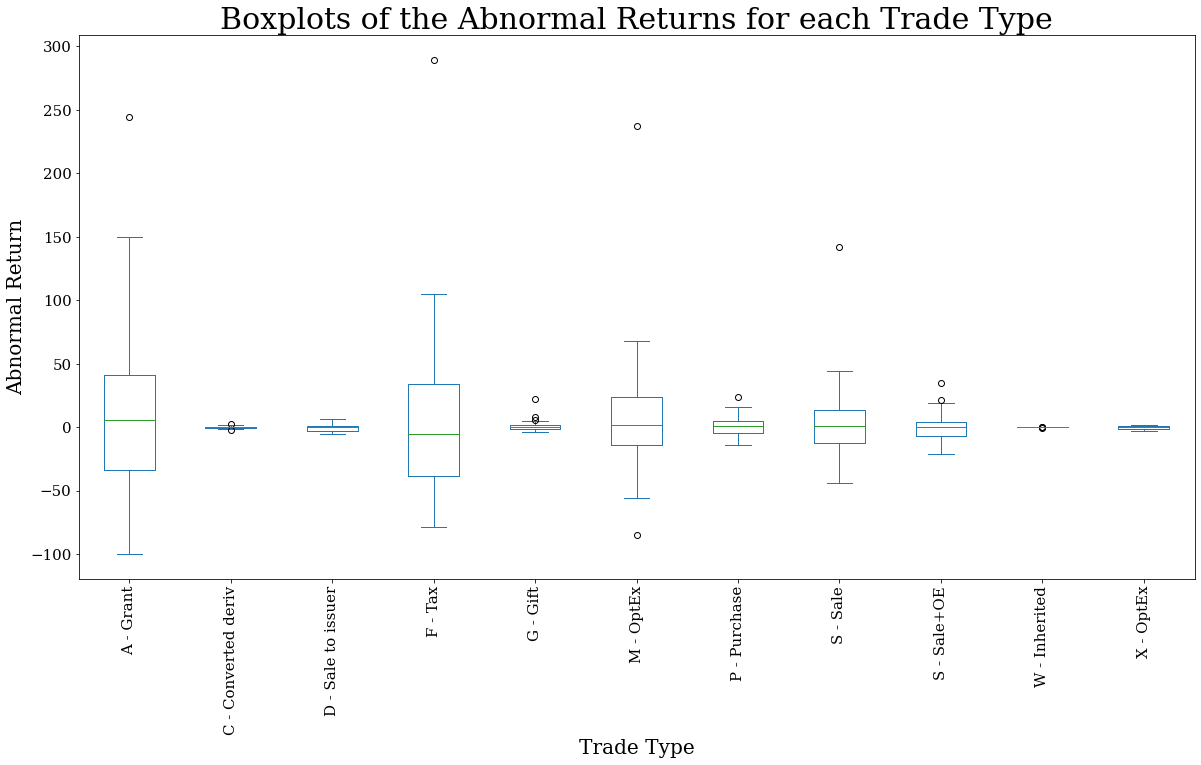

In [87]:
ax = df_abnormal_returns.groupby(level=[2]).sum().transpose().plot.box(rot=90, figsize=(fig_height, 10))
ax.set_title("Boxplots of the Abnormal Returns for each Trade Type",fontsize=title_size)
ax.set_xlabel("Trade Type", fontsize=label_size)
ax.set_ylabel("Abnormal Return", fontsize=label_size)

plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

plt.savefig(f"data/{NAME}/visualisations/AR_all_tradetypes_boxplot.svg", dpi=600, bbox_inches='tight')

In [88]:
types = list(set([x[2] for x in df_abnormal_returns.index]))
types

['S - Sale+OE',
 'G - Gift',
 'S - Sale',
 'M - OptEx',
 'P - Purchase',
 'D - Sale to issuer',
 'X - OptEx',
 'C - Converted deriv',
 'W - Inherited',
 'A - Grant',
 'F - Tax']

Specify the type of the trades to investigate

In [89]:
type_ = "P - Purchase" # "S - Sale"
df_abnormal_returns_type = df_abnormal_returns.loc[:,:,type_]

The index describes the company and the index of the filing in the compnay, the columns represent the days in the event window

In [90]:
df_abnormal_returns_type

0         1         2         3         4   \
Company i   event_timestamp                                                     
SLB     162 2021-02-11      -0.022133  0.010547 -0.018312  0.006488 -0.019138   
        163 2021-02-11      -0.022133  0.010547 -0.018312  0.006488 -0.019138   
        203 2021-02-11      -0.022133  0.010547 -0.018312  0.006488 -0.019138   
        204 2021-02-11      -0.022133  0.010547 -0.018312  0.006488 -0.019138   
        205 2021-02-11      -0.022133  0.010547 -0.018312  0.006488 -0.019138   
...                               ...       ...       ...       ...       ...   
AWK     43  2021-02-11       0.023160 -0.012939  0.016646 -0.006443  0.021674   
        106 2021-02-11       0.023160 -0.012939  0.016646 -0.006443  0.021674   
        174 2021-02-11       0.023160 -0.012939  0.016646 -0.006443  0.021674   
        227 2021-02-11       0.023160 -0.012939  0.016646 -0.006443  0.021674   
        230 2021-02-11       0.023160 -0.012939  0.016646 -0.006443  0.021674   

                                   5         6         7         8         9   \
Company i   event_timestamp                                                     
SLB     162 2021-02-11      -0.034308  0.018976 -0.025057 -0.032082  0.015824   
        163 2021-02-11      -0.034308  0.018976 -0.025057 -0.032082  0.015824   
        203 2021-02-11      -0.034308  0.018976 -0.025057 -0.032082  0.015824   
        204 2021-02-11      -0.034308  0.018976 -0.025057 -0.032082  0.015824   
        205 2021-02-11      -0.034308  0.018976 -0.025057 -0.032082  0.015824   
...                               ...       ...       ...       ...       ...   
AWK     43  2021-02-11      -0.012318  0.002635  0.002493 -0.009174 -0.001524   
        106 2021-02-11      -0.012318  0.002635  0.002493 -0.009174 -0.001524   
        174 2021-02-11      -0.012318  0.002635  0.002493 -0.009174 -0.001524   
        227 2021-02-11      -0.012318  0.002635  0.002493 -0.009174 -0.001524   
        230 2021-02-11      -0.012318  0.002635  0.002493 -0.009174 -0.001524   

                             ...        31        32        33        34  \
Company i   event_timestamp  ...                                           
SLB     162 2021-02-11       ... -0.018061 -0.012906  0.019432  0.042420   
        163 2021-02-11       ... -0.018061 -0.012906  0.019432  0.042420   
        203 2021-02-11       ... -0.018061 -0.012906  0.019432  0.042420   
        204 2021-02-11       ... -0.018061 -0.012906  0.019432  0.042420   
        205 2021-02-11       ... -0.018061 -0.012906  0.019432  0.042420   
...                          ...       ...       ...       ...       ...   
AWK     43  2021-02-11       ...  0.002801 -0.028449 -0.050857  0.030597   
        106 2021-02-11       ...  0.002801 -0.028449 -0.050857  0.030597   
        174 2021-02-11       ...  0.002801 -0.028449 -0.050857  0.030597   
        227 2021-02-11       ...  0.002801 -0.028449 -0.050857  0.030597   
        230 2021-02-11       ...  0.002801 -0.028449 -0.050857  0.030597   

                                   35        36        37        38        39  \
Company i   event_timestamp                                                     
SLB     162 2021-02-11      -0.026402  0.016615 -0.024881 -0.000778 -0.036515   
        163 2021-02-11      -0.026402  0.016615 -0.024881 -0.000778 -0.036515   
        203 2021-02-11      -0.026402  0.016615 -0.024881 -0.000778 -0.036515   
        204 2021-02-11      -0.026402  0.016615 -0.024881 -0.000778 -0.036515   
        205 2021-02-11      -0.026402  0.016615 -0.024881 -0.000778 -0.036515   
...                               ...       ...       ...       ...       ...   
AWK     43  2021-02-11      -0.003598 -0.017133  0.018804 -0.008793  0.000127   
        106 2021-02-11      -0.003598 -0.017133  0.018804 -0.008793  0.000127   
        174 2021-02-11      -0.003598 -0.017133  0.018804 -0.008793  0.000127   
        227 2021-02-11      -0.003598 -0.017133

<AxesSubplot:>

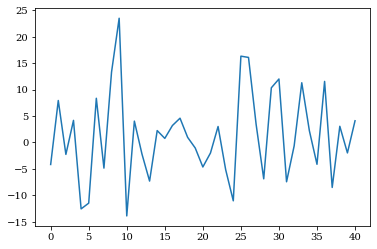

In [91]:
CAR = df_abnormal_returns_type.sum(axis=0)
CAR.plot()

![alt text](assets/images/cross_sectional_agg.png)


<AxesSubplot:>

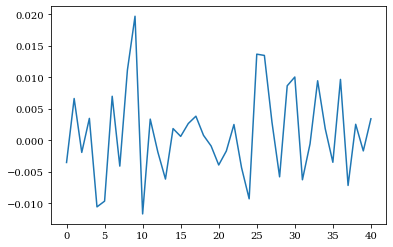

In [92]:
AR_bar = df_abnormal_returns_type.mean(axis=0) 
AR_bar.plot()

In [93]:
CAR_bar = AR_bar.sum()
CAR_bar

0.045300562319014276

In [94]:
# TODO var_CAR_bar = Does the definition make sense? It seems like we take the var of a scalar

![alt text](assets/images/cross_sectional_agg2.png)


In [95]:
CAR_bar_2 = CAR.mean()
CAR_bar_2

1.3170309825430495

In [96]:
# var car TODO not sure what just sigma means.

## Statistics

Check if CAR mean = 0 (t-test)

In [97]:

tt = stats.ttest_1samp(CAR, popmean=0)
tt

Ttest_1sampResult(statistic=0.9883259774578566, pvalue=0.3289340399757267)

Check if CAR median = 0 (wilcoxon signed rank test)

In [98]:
stats.wilcoxon(CAR)

WilcoxonResult(statistic=378.0, pvalue=0.49630576469136267)

In [99]:
types = types
investigation_periods = investigation_periods
multiind_p, data_p = [], []

event_day_ranges = {
    "before": (0,20), # TODO for now we drop the filing day itself
    "after": (21,41)
}

aggregation_type = {"name": "cross-sectional", "axis":0}
#aggregation_type = {"name": "through time", "axis":1}

for type_ in types:
    for per in investigation_periods.keys():
        for side in event_day_ranges.keys():
                
            event_day_range = event_day_ranges[side]
            df_abnormal_returns_type = df_abnormal_returns.loc[:,:,type_]
            per_left, per_right = investigation_periods[per]


            timestamps = df_abnormal_returns_type.index.get_level_values(2)
            mask = (timestamps >= per_left) & (timestamps <= per_right)
            df_AR_type_per = df_abnormal_returns_type[mask]
            if not len(df_AR_type_per):
                print(f"skipping iteration because of 0 datapoints {(type_, per, side)}")
                continue
            df_AR_type_per_side = df_AR_type_per.iloc[:,event_day_range[0]:event_day_range[1]]
            CAR = df_AR_type_per_side.mean(axis=aggregation_type["axis"])

            pvalue_ttest = round(stats.ttest_1samp(CAR, popmean=0).pvalue, 10)
            pvalue_wilcoxon = round(stats.wilcoxon(CAR).pvalue, 10)
            mean = CAR.mean()
            median = CAR.median()
            # calculate a 95% confidence interval
            left, right = stats.t.interval(0.95, len(CAR)-1, loc=np.mean(CAR), scale=stats.sem(CAR))
            left, right = round(left, 4), round(right, 4)
            CI = left, right
            
            multiind_p.append((type_, per, side))
            data_p.append((mean, pvalue_ttest, median, pvalue_wilcoxon, len(df_AR_type_per), CI))

skipping iteration because of 0 datapoints ('S - Sale+OE', 'pre-pandemic', 'before')
skipping iteration because of 0 datapoints ('S - Sale+OE', 'pre-pandemic', 'after')
skipping iteration because of 0 datapoints ('G - Gift', 'pre-pandemic', 'before')
skipping iteration because of 0 datapoints ('G - Gift', 'pre-pandemic', 'after')
skipping iteration because of 0 datapoints ('S - Sale', 'pre-pandemic', 'before')
skipping iteration because of 0 datapoints ('S - Sale', 'pre-pandemic', 'after')
skipping iteration because of 0 datapoints ('M - OptEx', 'pre-pandemic', 'before')
skipping iteration because of 0 datapoints ('M - OptEx', 'pre-pandemic', 'after')
skipping iteration because of 0 datapoints ('P - Purchase', 'pre-pandemic', 'before')
skipping iteration because of 0 datapoints ('P - Purchase', 'pre-pandemic', 'after')
skipping iteration because of 0 datapoints ('D - Sale to issuer', 'pre-pandemic', 'before')
skipping iteration because of 0 datapoints ('D - Sale to issuer', 'pre-pandem

In [100]:
# process abnormal returns
df_p = pd.DataFrame.from_records(data_p)
df_p.index = pd.MultiIndex.from_tuples(multiind_p, names=["TradeType", "Period", "Side"])
df_p.columns = ["mean", "ttest pvalue", "median", "wilcoxon pvalue", "sample_size", "95% CI"]
df_p.to_csv(f"data/{NAME}/{aggregation_type['name']}_tests_result.csv")
df_p.sort_values("ttest pvalue")

mean  ttest pvalue    median  \
TradeType           Period   Side                                       
A - Grant           pandemic after   0.001888      0.149917  0.001496   
                    overall  after   0.001888      0.149917  0.001496   
F - Tax             pandemic after   0.001815      0.214614  0.002465   
                    overall  after   0.001815      0.214614  0.002465   
M - OptEx           pandemic after   0.001568      0.238011  0.001952   
                    overall  after   0.001568      0.238011  0.001952   
P - Purchase        overall  after   0.001909      0.239716  0.002187   
                    pandemic after   0.001909      0.239716  0.002187   
W - Inherited       pandemic after   0.005017      0.240007  0.006242   
                    overall  after   0.005017      0.240007  0.006242   
X - OptEx           pandemic before -0.003842      0.262241 -0.004035   
                    overall  before -0.003842      0.262241 -0.004035   
                             after  -0.004557      0.306250 -0.000809   
                    pandemic after  -0.004557      0.306250 -0.000809   
G - Gift            pandemic before  0.001815      0.355568  0.000186   
                    overall  before  0.001815      0.355568  0.000186   
S - Sale            overall  before  0.001820      0.422211  0.000354   
                    pandemic before  0.001820      0.422211  0.000354   
D - Sale to issuer  pandemic after  -0.000871      0.451978  0.000666   
                    overall  after  -0.000871      0.451978  0.000666   
G - Gift            overall  after   0.000681      0.469333 -0.000323   
                    pandemic after   0.000681      0.469333 -0.000323   
S - Sale+OE         overall  after  -0.000699      0.551996 -0.000346   
                    pandemic after  -0.000699      0.551996 -0.000346   
D - Sale to issuer  overall  before -0.000692      0.578238  0.000922   
                    pandemic before -0.000692      0.578238  0.000922   
S - Sale            pandemic after   0.000672      0.605720 -0.000360   
                    overall  after   0.000672      0.605720 -0.000360   
W - Inherited       pandemic before  0.001091      0.606859  0.001047   
                    overall  before  0.001091      0.606859  0.001047   
M - OptEx           pandemic before  0.001539      0.628551 -0.001771   
                    overall  before  0.001539      0.628551 -0.001771   
S - Sale+OE         pandemic before  0.000660      0.658567  0.000308   
                    overall  before  0.000660      0.658567  0.000308   
P - Purchase        overall  before  0.000551      0.745547  0.000722   
                    pandemic before  0.000551      0.745547  0.000722   
C - Converted deriv pandemic before  0.000557      0.779109 -0.000842   
                    overall  before  0.000557      0.779109 -0.000842   
F - Tax             overall  before  0.000398      0.853198 -0.001641   
                    pandemic before  0.000398      0.853198 -0.001641   
C - Converted deriv overall  after  -0.000244      0.889811 -0.000910   
                    pandemic after  -0.000244      0.889811 -0.000910   
A - Grant           overall  before  0.000167      0.908939 -0.000896   
                    pandemic before  0.000167      0.908939 -0.000896   

                                     wilcoxon pvalue  sample_size  \
TradeType           Period   Side                                   
A - Grant           pandemic after          0.202450        11506   
                    overall  after          0.202450        11506   
F - Tax             pandemic after          0.261099         8293   
                    overall  after          0.261099         8293   
M - OptEx           pandemic after          0.277355         4589   
                    overall  after          0.277355         4589   
P - Purchase        overall  after          0.294252         1192   
                    pandemic after          0.294252         

In [101]:
df_p.loc["S - Sale"]

mean  ttest pvalue    median  wilcoxon pvalue  \
Period   Side                                                        
overall  before  0.001820      0.422211  0.000354         0.898317   
         after   0.000672      0.605720 -0.000360         0.728506   
pandemic before  0.001820      0.422211  0.000354         0.898317   
         after   0.000672      0.605720 -0.000360         0.728506   

                 sample_size             95% CI  
Period   Side                                    
overall  before         3640  (-0.0028, 0.0065)  
         after          3640   (-0.002, 0.0034)  
pandemic before         3640  (-0.0028, 0.0065)  
         after          3640   (-0.002, 0.0034)

#### Export information to latex

In [102]:
counter = 0
for t in types:
    counter = counter+1
    #print(t)
    df_ = df_p.loc[t,:,:]
    df_ = df_.rename(columns={'Side of the event': 'Side'
                              , 'mean': 'mean'
                              , 'ttest pvalue': 'ttest'
                              , 'median': 'median'
                              , 'wilcoxon pvalue': 'Wilcoxon'
                              , 'sample_size': 'N'})
    #display(df_)
    
    latex = df_.drop(columns=["95% CI"])\
    .to_latex( column_format="llrrrrr"
              , position="H"
              , label=f"table:t{counter}_hypothesistest"
              , caption= f"Hypothesis tests for type: {t}"
              #, index = False
    )
    print(latex)

C:\Users\Tom\AppData\Local\Temp\ipykernel_25036\3459092443.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df_.drop(columns=["95% CI"])\
C:\Users\Tom\AppData\Local\Temp\ipykernel_25036\3459092443.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df_.drop(columns=["95% CI"])\
C:\Users\Tom\AppData\Local\Temp\ipykernel_25036\3459092443.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler

\begin{table}[H]
\centering
\caption{Hypothesis tests for type: S - Sale+OE}
\label{table:t1_hypothesistest}
\begin{tabular}{llrrrrr}
\toprule
         &       &      mean &     ttest &    median &  Wilcoxon &     N \\
Period & Side &           &           &           &           &       \\
\midrule
overall & before &  0.000660 &  0.658567 &  0.000308 &  1.000000 &  1816 \\
         & after & -0.000699 &  0.551996 & -0.000346 &  0.570597 &  1816 \\
pandemic & before &  0.000660 &  0.658567 &  0.000308 &  1.000000 &  1816 \\
         & after & -0.000699 &  0.551996 & -0.000346 &  0.570597 &  1816 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[H]
\centering
\caption{Hypothesis tests for type: G - Gift}
\label{table:t2_hypothesistest}
\begin{tabular}{llrrrrr}
\toprule
         &       &      mean &     ttest &    median &  Wilcoxon &    N \\
Period & Side &           &           &           &           &      \\
\midrule
overall & before &  0.001815 &  0.355568 &  0.000186 &  0.7

C:\Users\Tom\AppData\Local\Temp\ipykernel_25036\3459092443.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df_.drop(columns=["95% CI"])\
C:\Users\Tom\AppData\Local\Temp\ipykernel_25036\3459092443.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df_.drop(columns=["95% CI"])\


### Visualise CI

# Time based aggregation

In order to compare pre-pandemic and pandemic time, we cannot do aggregation through time because then we cannot carry out hypothesis tests. Therefore we aggregate the data in time and do a 2 sample t test

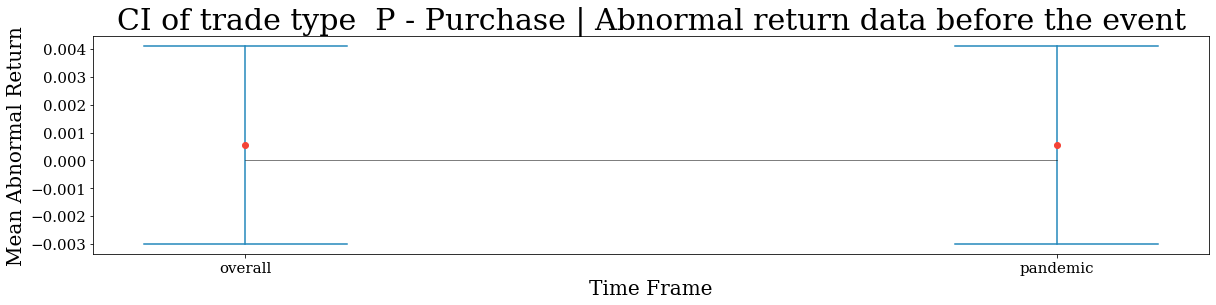

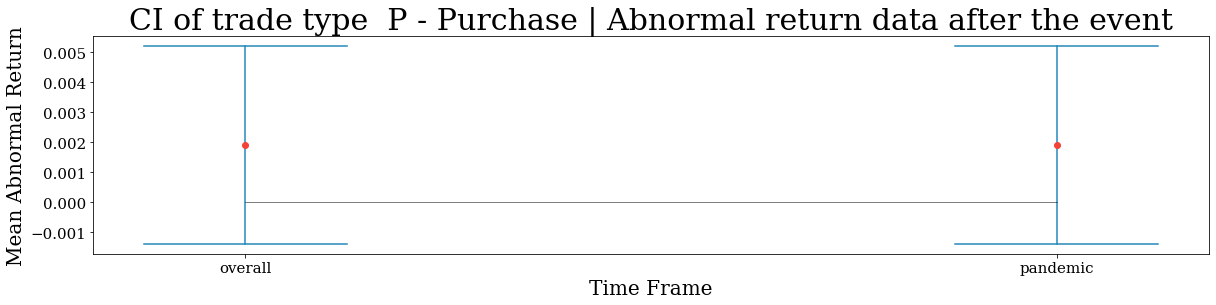

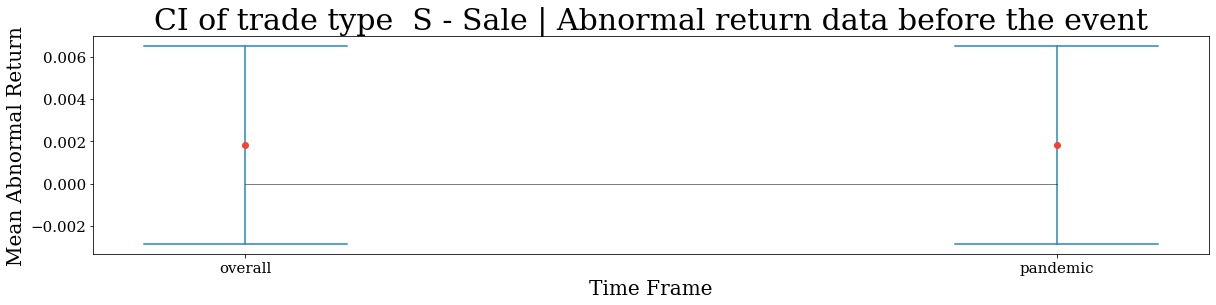

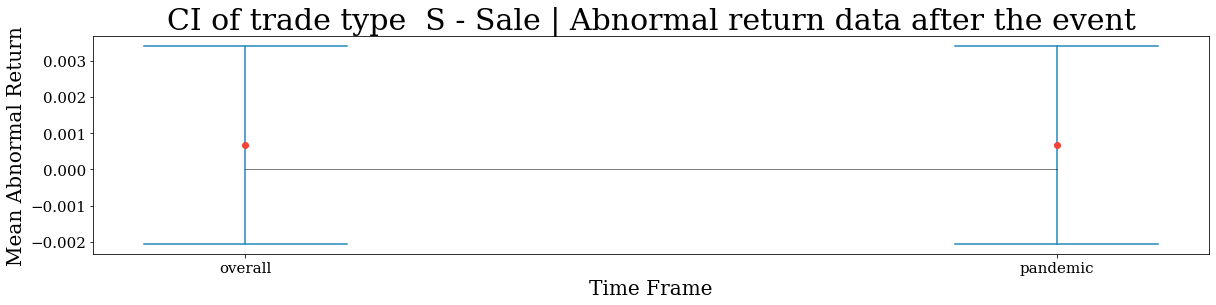

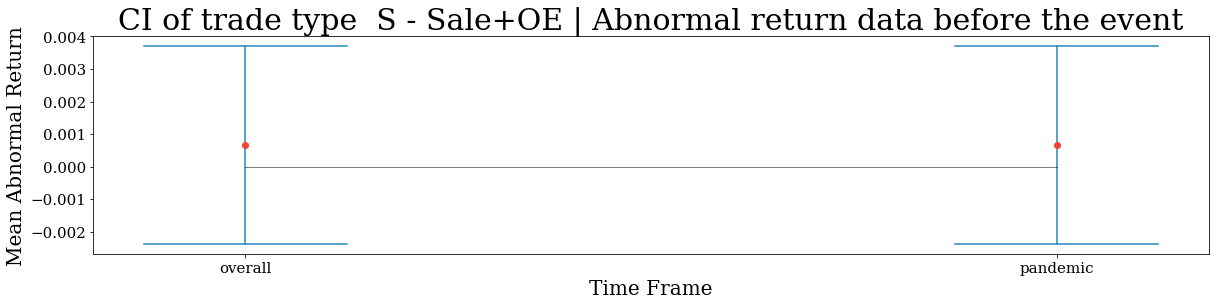

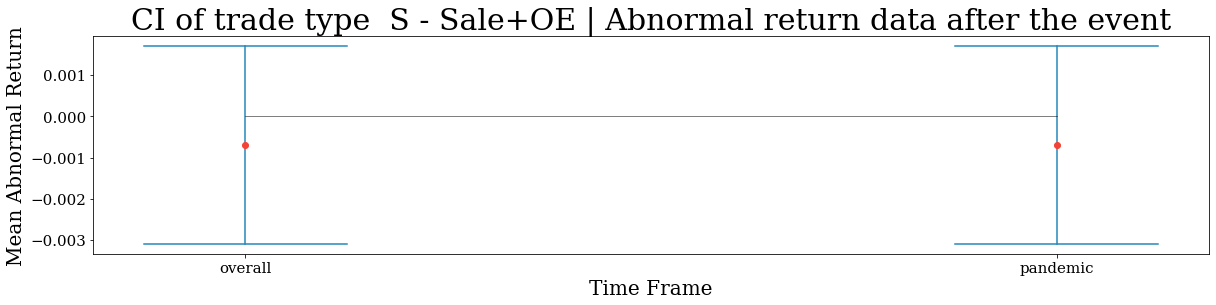

In [103]:
# purcase, sale and sale with oe
for t in types_of_interest:
    for side in event_day_ranges.keys():

        df_ = df_p.loc[t,:,side]

        def plot_confidence_interval(x, mean, CI, color='#2187bb', horizontal_line_width=0.25):


            left = x - horizontal_line_width / 2
            top = mean - CI
            right = x + horizontal_line_width / 2
            bottom = mean + CI
            plt.plot([x, x], [top, bottom], color=color)
            plt.plot([left, right], [top, top], color=color)
            plt.plot([left, right], [bottom, bottom], color=color)
            plt.plot(x, mean, 'o', color='#f44336')

            return mean, CI

        plt.figure(figsize=(fig_height,4))

        df_to_plot = df_
        for i, row in enumerate(df_to_plot.sort_values("mean").itertuples()):
            mean, CI = plot_confidence_interval(i, row[1], row[6][1] - row[1])

        plt.plot(np.zeros(len(df_to_plot)), color="black", linewidth=0.5)
        plt.xticks(range(len(df_to_plot)), df_to_plot.index, fontsize=tick_size)
        plt.yticks(fontsize=tick_size)

        if side == "before":
            side_desc = "before the event"
        else:
            side_desc = "after the event"

        plt.title(f'CI of trade type  {t} | Abnormal return data {side_desc}', fontsize=title_size)

        plt.xlabel('Time Frame', fontsize=label_size)
        plt.ylabel('Mean Abnormal Return', fontsize=label_size)

        plt.xticks(fontsize=tick_size)
        plt.yticks(fontsize=tick_size)
        plt.savefig(f"data/{NAME}/visualisations/CI_{t}_{side}.svg", dpi=600, bbox_inches='tight')
        plt.show()

C:\Users\Tom\AppData\Roaming\Python\Python38\site-packages\matplotlib\axes\_axes.py:6607: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\Tom\AppData\Roaming\Python\Python38\site-packages\matplotlib\axes\_axes.py:6608: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

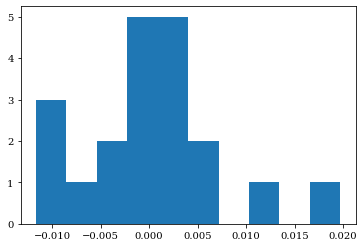

In [104]:
time_aggregated = df_abnormal_returns.sum(axis=1)#.transpose()
matrix_data = dict()

for side in event_day_ranges.keys():
    d = {}
    for t in types_of_interest:

        event_day_range = event_day_ranges[side]
        df_abnormal_returns_type = df_abnormal_returns.loc[:,:,t]

        timestamps = df_abnormal_returns_type.index.get_level_values(2)

        df_AR_type_side = df_abnormal_returns_type.iloc[:,event_day_range[0]:event_day_range[1]]


        pand_start, pand_end = investigation_periods["pandemic"][0], investigation_periods["pandemic"][1]
        prepand_start, prepand_end = investigation_periods["pre-pandemic"][0], investigation_periods["pre-pandemic"][1]

        mask_pand = (timestamps >= pand_start) & (timestamps <= pand_end)
        mask_prepand = (timestamps >= prepand_start) & (timestamps <= prepand_end)


        df_AR_type_side_pand_agg = df_AR_type_side[mask_pand].mean(axis=0)
        df_AR_type_side_prepand_agg = df_AR_type_side[mask_prepand].mean(axis=0)
        plt.hist(df_AR_type_side_pand_agg)
        plt.hist(df_AR_type_side_prepand_agg)
        plt.show()

        tt = stats.ttest_ind(a=df_AR_type_side_prepand_agg, b=df_AR_type_side_pand_agg)
        print(f"For type {t}, in the days {side} of the event, the pre-pandemic and pandemic mean of abnormal returns is different with a p-value of {round(tt.pvalue, 10)}")

        d.update({t:tt.pvalue})

    matrix_data[side] = d

### P-values of whether pre-pandemic and pandemic are significantly different for the timeframe before and after the event and different types

In [ ]:
print(pd.DataFrame.from_dict(matrix_data).to_latex())

Specify the type of the trades to investigate

### Visualize how active Directors Dealings Are
Should move this to somewhere else
Want visual confirmation that Directors have changed behaviour during the times of Covid (Hypothesis 3)

In [ ]:
all_insider_trades = companies[0].insider_data_df.head(0)

#for j in tqdm(range(len(companies[:200]))):
for j in tqdm(range(len(companies))):
    all_insider_trades = pd.concat([all_insider_trades, companies[j].insider_data_df])

In [ ]:
all_insider_trades['FilingDateTrunc'] = all_insider_trades['FilingDate'].dt.date
all_insider_trades.groupby('FilingDateTrunc')['FilingDate'].count().plot()

In [ ]:
all_insider_trades.to_csv('AllTradesForExcelGSK.csv')

In [ ]:
all_insider_trades.groupby('FilingDateTrunc')['Value'].sum().plot()

In [ ]:
all_insider_trades.groupby('FilingDateTrunc')['Value'].mean().plot()

In [ ]:
plt.hist(all_insider_trades['FilingDateTrunc'])

In [ ]:
plt.rc('font', family='serif')
plt.rc('xtick')
plt.rc('ytick')

fig = plt.figure(figsize=(fig_height, 10))
ax = fig.add_subplot(1, 1, 1)

returns_companies = df_returns.mean(axis=1)
returns_companies.plot(color="k", linewidth=0.7)

ax.set_xlabel('Time (Years)', fontsize=label_size)
ax.set_ylabel('Mean Daily Return', fontsize=label_size)
ax.set_title('Mean Daily Returns Over Time', fontsize=title_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

interval_borders = ["2018-01-01", "2020-03-01", "2021-12-31"] # TODO see if it makes sense to actually take first of Feb

for int_ in interval_borders:
    plt.axvline(x = int_, color = 'red', label = 'DD Event time', linewidth = 1)

#plt.savefig(DATA_LOCATION +"visualisations/NYSE_daily_returns.svg", dpi=600)
plt.show()
# get var for the intervals
print("variance of the intervals")
print(f'{round(returns_companies.loc["2018-01-01":"2020-02-29"].var(),10):.20f}')
print(f'{round(returns_companies.loc["2020-03-01":"2021-12-31"].var(), 10):.20f}')


In [ ]:
all_insider_trades['FilingDateTrunc'] = all_insider_trades['FilingDate'].dt.date
all_insider_trades.groupby('FilingDateTrunc')['FilingDate'].count().plot()

In [ ]:
all_insider_trades.to_csv('AllTradesForExcelGSK.csv')

In [ ]:
all_insider_trades.groupby('FilingDateTrunc')['Value'].sum().plot()

In [ ]:
all_insider_trades.groupby('FilingDateTrunc')['Value'].mean().plot()

In [ ]:
plt.hist(all_insider_trades['FilingDateTrunc'])

In [ ]:
plt.rc('font', family='serif')
plt.rc('xtick')
plt.rc('ytick')

fig = plt.figure(figsize=(fig_height, 10))
ax = fig.add_subplot(1, 1, 1)

returns_companies = df_returns.mean(axis=1)
returns_companies.plot(color="k", linewidth=0.7)

ax.set_xlabel('Time (Years)', fontsize=label_size)
ax.set_ylabel('Mean Daily Return', fontsize=label_size)
ax.set_title('Mean Daily Returns Over Time', fontsize=title_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

interval_borders = ["2018-01-01", "2020-03-01", "2021-12-31"] # TODO see if it makes sense to actually take first of Feb

for int_ in interval_borders:
    plt.axvline(x = int_, color = 'red', label = 'DD Event time', linewidth = 1)

#plt.savefig(DATA_LOCATION +"visualisations/NYSE_daily_returns.svg", dpi=600)
plt.show()
# get var for the intervals
print("variance of the intervals")
print(f'{round(returns_companies.loc["2018-01-01":"2020-02-29"].var(),10):.20f}')
print(f'{round(returns_companies.loc["2020-03-01":"2021-12-31"].var(), 10):.20f}')